In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
from torch import nn
from torchvision import transforms

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
train_dir = "D:/Research/Data/Train_data"
test_dir = "D:/Research/Data/Test_data"
print(train_dir)

D:/Research/Data/Train_data


In [5]:
import os

In [6]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

Num_workers = os.cpu_count()
Num_workers

def create_dataloaders(
    train_dir : str,
    test_dir : str,
    transform : transforms.Compose,
    batch_size : int,
    num_workers : int = Num_workers
):
    train_data = datasets.ImageFolder(train_dir,transform = transform)
    test_data = datasets.ImageFolder(test_dir,transform = transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers,
        pin_memory = True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = num_workers,
        pin_memory = True,
    )

    return train_dataloader, test_dataloader, class_names

In [7]:
img_sz = 224

manual_transforms = transforms.Compose([
    transforms.Resize((img_sz, img_sz)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1263d3f45c0>,
 ['Abnormal', 'Normal'])

torch.Size([3, 224, 224]) tensor(0)


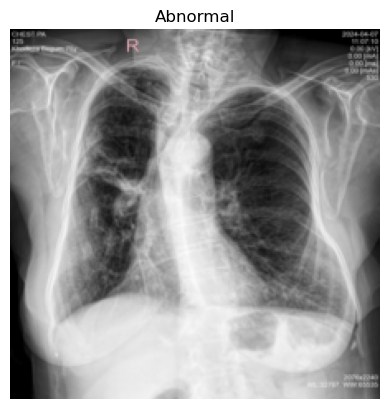

In [9]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)

        self.flatten = nn.Flatten(start_dim=2,end_dim=3)
    def forward(self, x):

        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

In [11]:
patch_size = 16

def set_seeds(seed: int=42):
    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)

set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [12]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.2798,  0.1442, -0.2112,  ...,  0.3707, -0.1267,  0.1228],
         [-0.3059,  0.0502, -0.2596,  ...,  0.3195, -0.1260,  0.1836],
         [-0.3336,  0.0350, -0.2947,  ...,  0.2885, -0.0434,  0.2029],
         ...,
         [-0.8192,  0.1833, -0.2859,  ...,  0.5932, -0.3294,  0.3298],
         [-0.6156,  0.1567, -0.2230,  ...,  0.4386, -0.2919,  0.2894],
         [-0.4105,  0.0540, -0.1343,  ...,  0.3168, -0.2662,  0.1986]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [13]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")


number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2798,  0.1442, -0.2112,  ...,  0.3707, -0.1267,  0.1228],
         [-0.3059,  0.0502, -0.2596,  ...,  0.3195, -0.1260,  0.1836],
         ...,
         [-0.8192,  0.1833, -0.2859,  ...,  0.5932, -0.3294,  0.3298],
         [-0.6156,  0.1567, -0.2230,  ...,  0.4386, -0.2919,  0.2894],
         [-0.4105,  0.0540, -0.1343,  ...,  0.3168, -0.2662,  0.1986]]],
       grad_fn=<CatBackward0>)


In [14]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                            num_heads=num_heads,
                                            dropout=attn_dropout,
                                            batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output

In [15]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [16]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x

        x = self.mlp_block(x) + x

        return x

In [17]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model=transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [18]:
print("Hello")

Hello


In [19]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisivle by patch size, image size: {img_size},patch size: {patch_size}"

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1, embedding_dim),
                                                requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size = patch_size,
                                              embedding_dim=embedding_dim)


        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                        out_features=num_classes)
        )


    def forward(self, x):

            batch_size = x.shape[0]

            class_token = self.class_embedding.expand(batch_size, -1, -1)

            x = self.patch_embedding(x)

            x = torch.cat((class_token, x), dim=1)

            x = self.position_embedding + x

            x = self.embedding_dropout(x)

            x = self.transformer_encoder(x)

            x = self.classifier(x[:, 0])

            return x

In [20]:
vit = ViT(num_classes=len(class_names))

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=1,
                       device=device)

  0%|          | 0/1 [00:00<?, ?it/s]